# Imports

In [117]:
import os
from pathlib import Path
from typing import List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# Analisis preliminar y Limpieza

In [3]:
data = pd.read_csv(Path(os.getcwd()).joinpath('data', 'dataset_SCL.csv'))
print(f'Shape of dataframe: {data.shape}')
data.sample(frac=0.0001, random_state=12)

Shape of dataframe: (68206, 18)


C:\Users\Bastian\AppData\Local\Temp\ipykernel_14384\162653823.py:1: DtypeWarning: Columns (1,6) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(Path(os.getcwd()).joinpath('data', 'dataset_SCL.csv'))


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
58560,2017-11-29 08:35:00,148,SCEL,SCCF,LAN,2017-11-29 08:29:00,148,SCEL,SCCF,LAN,29,11,2017,Miercoles,N,Grupo LATAM,Santiago,Calama
63027,2017-12-04 00:35:00,9643,SCEL,SBGR,TAM,2017-12-04 00:45:00,9643,SCEL,SBGR,TAM,4,12,2017,Lunes,I,Grupo LATAM,Santiago,Sao Paulo
66340,2017-12-16 15:35:00,410,SCEL,SUMU,LAN,2017-12-16 15:57:00,410.0,SCEL,SUMU,LAN,16,12,2017,Sabado,I,Grupo LATAM,Santiago,Montevideo
63215,2017-12-01 19:15:00,25,SCEL,SCTE,SKU,2017-12-01 20:00:00,25,SCEL,SCTE,SKU,1,12,2017,Viernes,N,Sky Airline,Santiago,Puerto Montt
49004,2017-09-05 19:10:00,704,SCEL,LEMD,LAN,2017-09-05 19:08:00,704,SCEL,LEMD,LAN,5,9,2017,Martes,I,Grupo LATAM,Santiago,Madrid
67741,2017-12-24 16:30:00,54,SCEL,SCFA,LAW,2017-12-24 16:32:00,54.0,SCEL,SCFA,JMR,24,12,2017,Domingo,N,Latin American Wings,Santiago,Antofagasta
6446,2017-02-16 16:16:00,116,SCEL,SKBO,AVA,2017-02-16 16:20:00,116,SCEL,SKBO,AVA,16,2,2017,Jueves,I,Avianca,Santiago,Bogota


Vemos que, a priori, en general la informacion de programacion es igual a la de operacion de vuelo (salvo la hora de vuelo, que es el problema a predecir), pero hay casos donde la aerolinea no es la misma. Addemas, 'OPERA' pareciera indicar la misma informacion que 'Emp-I' y no 'Emp-O', ya que Latin American Wings probablemente corresponde con la sigla LAW y no con JMR.

In [4]:
# get data where Des-I is different from Des-O
data[data["Des-I"] != data["Des-O"]].sample(frac = 0.3, random_state = 42)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
20444,2017-04-14 22:00:00,289,SCEL,SCTE,LAN,2017-04-14 22:01:00,289,SCEL,SCCI,LXP,14,4,2017,Viernes,N,Grupo LATAM,Santiago,Punta Arenas
67600,2017-12-02 11:15:00,7811,SCEL,SAEZ,LAN,2017-12-02 11:21:00,7811.0,SCEL,SABE,DSM,2,12,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires
18293,2017-04-14 18:40:00,25,SCEL,SCTE,SKU,2017-04-14 18:48:00,25,SCEL,SCQP,SKU,14,4,2017,Viernes,N,Sky Airline,Santiago,Temuco
55144,2017-10-06 00:55:00,1260,SCEL,SEQU,LAN,2017-10-06 02:15:00,1260,SCEL,SEQM,LAN,6,10,2017,Viernes,I,Grupo LATAM,Santiago,Quito
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,17,1,2017,Martes,N,Sky Airline,Santiago,Temuco
25422,2017-05-12 08:25:00,271,SCEL,SCBA,LAN,2017-05-12 08:36:00,271,SCEL,SCTE,LXP,12,5,2017,Viernes,N,Grupo LATAM,Santiago,Puerto Montt
38135,2017-07-17 16:00:00,7813,SCEL,SABE,LAN,2017-07-17 16:41:00,1113,SCEL,SAEZ,LAN,17,7,2017,Lunes,I,Grupo LATAM,Santiago,Buenos Aires
61463,2017-11-06 06:00:00,1031,SCEL,SCIE,LAW,2017-11-06 08:01:00,1031,SCEL,SCTE,JMR,6,11,2017,Lunes,N,Latin American Wings,Santiago,Puerto Montt


Aqui vemos que en algunos casos el destino de vuelo tambien cambia entre la informacion de programacion y operacion. Ademas, en este caso 'SIGLADES' no indica la misma informacion de 'Des-I', si no que la de 'Des-O', lo que se puede ver porque las siglas de Puerto Montt y Temuco coinciden para 'Des-O' y no para 'Des-I'.

In [5]:
# get data where Ori-I is different from Ori-O
data[data["Ori-I"] != data["Ori-O"]]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Para la ciudad de origen, los datos de programacion vs operacion coinciden perfectamente

In [6]:
# get data where Vlo-I is different from Vlo-O
data[data["Vlo-I"] != data["Vlo-O"]].sample(frac = 0.002, random_state = 42)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
63920,2017-12-25 04:00:00,170,SCEL,SCDA,SKU,2017-12-25 03:50:00,170.0,SCEL,SCDA,SKU,25,12,2017,Lunes,N,Sky Airline,Santiago,Iquique
65253,2017-12-07 17:32:00,213,SCEL,SCIE,LAN,2017-12-07 17:41:00,213.0,SCEL,SCIE,LXP,7,12,2017,Jueves,N,Grupo LATAM,Santiago,Concepcion
64173,2017-12-21 21:10:00,503,SCEL,SAEZ,SKU,2017-12-21 22:03:00,503.0,SCEL,SAEZ,SKU,21,12,2017,Jueves,I,Sky Airline,Santiago,Buenos Aires
64486,2017-12-24 09:38:00,61,SCEL,SCTE,LAN,2017-12-24 09:45:00,61.0,SCEL,SCTE,LAN,24,12,2017,Domingo,N,Grupo LATAM,Santiago,Puerto Montt


En el caso del numero de vuelo, ocurre que algunos datos fueron guardados como float y cargados como texto, por lo que habria que cambiarlos a int, pero como pandas no los transformó a numerico automaticamente, probablemente haya otro problema tambien

In [7]:
# get data where Vlo-O cannot be converted into numeric
not_num_mask = pd.to_numeric(data["Vlo-O"], errors='coerce').isna() 
data.loc[not_num_mask, :].sample(frac = 0.5, random_state = 42)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
13906,2017-03-30 10:30:00,71,SCEL,SCIE,SKU,2017-03-30 10:50:00,71R,SCEL,SCIE,SKU,30,3,2017,Jueves,N,Sky Airline,Santiago,Concepcion
22167,2017-04-06 21:10:00,43,SCEL,SCIE,LAW,2017-04-06 21:24:00,43R,SCEL,SCIE,JMR,6,4,2017,Jueves,N,Latin American Wings,Santiago,Concepcion
55354,2017-10-19 03:30:00,502,SCEL,KMIA,LAN,2017-10-19 03:33:00,502R,SCEL,KMIA,LAN,19,10,2017,Jueves,I,Grupo LATAM,Santiago,Miami
32196,2017-06-29 12:40:00,492,SCEL,SACO,LAN,2017-06-29 12:27:00,492R,SCEL,SACO,LAN,29,6,2017,Jueves,I,Grupo LATAM,Santiago,Cordoba
44939,2017-09-28 21:30:00,846,SCEL,KIAH,UAL,2017-09-28 21:44:00,846A,SCEL,KIAH,UAL,28,9,2017,Jueves,I,United Airlines,Santiago,Houston
24304,2017-05-11 10:00:00,802,SCEL,SPJC,SKU,2017-05-11 10:36:00,802R,SCEL,SPJC,SKU,11,5,2017,Jueves,I,Sky Airline,Santiago,Lima
39225,2017-08-07 19:00:00,591P,SCEL,LFPG,PUE,2017-08-07 20:35:00,591P,SCEL,LFPG,PUE,7,8,2017,Lunes,I,Plus Ultra Lineas Aereas,Santiago,Paris


Vemos que los valores que no pueden ser convertidos se deben a que tienen letras luego del numero, esto tambien ocurre en 'Vlo-I'; ademas, se nota un NaN.

Entonces, nos deshacemos de las letras en los numeros de vuelo

In [8]:
# only keep numeric values in the string
data["Vlo-O"] = data["Vlo-O"].map(lambda x: ''.join([i for i in str(x) if i.isdigit()]))
data["Vlo-I"] = data["Vlo-I"].map(lambda x: ''.join([i for i in str(x) if i.isdigit()]))

# get data where Vlo-O cannot be converted into numeric
not_num_mask = pd.to_numeric(data["Vlo-O"], errors='coerce').isna() 
data.loc[not_num_mask, :]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Vemos que ahora solo hay un valor no numerico, que corresponde al NaN de antes; el cual se eliminará

In [9]:
data.drop(labels=6068, axis=0, inplace=True)

Ahora vemos que numeros de vuelo son distintos

In [10]:
# get data where Vlo-I is different from Vlo-O
data[data["Vlo-I"] != data["Vlo-O"]].sample(frac = 0.001, random_state = 42)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
65339,2017-12-18 07:25:00,231,SCEL,SCQP,LAN,2017-12-18 07:38:00,2310,SCEL,SCQP,LXP,18,12,2017,Lunes,N,Grupo LATAM,Santiago,Temuco
67392,2017-12-09 12:20:00,1193,SCEL,SCCI,LAN,2017-12-09 12:20:00,11930,SCEL,SCCI,LXP,9,12,2017,Sabado,N,Grupo LATAM,Santiago,Punta Arenas
67949,2017-12-12 05:00:00,26,SCEL,SCFA,JAT,2017-12-12 05:16:00,260,SCEL,SCFA,JAT,12,12,2017,Martes,N,JetSmart SPA,Santiago,Antofagasta
67710,2017-12-07 05:00:00,50,SCEL,SCFA,LAW,2017-12-07 04:55:00,500,SCEL,SCFA,JMR,7,12,2017,Jueves,N,Latin American Wings,Santiago,Antofagasta
64173,2017-12-21 21:10:00,503,SCEL,SAEZ,SKU,2017-12-21 22:03:00,5030,SCEL,SAEZ,SKU,21,12,2017,Jueves,I,Sky Airline,Santiago,Buenos Aires


Vemos que ahora hay un problema con numeros de vuelo con un 0 extra al final, si se eliminace de la misma manera que el anterior, se corre el riesgo de eliminar un 0 que no sea extra, haciendo que un vuelo que si era igual, ahora no lo sea; por lo que se trabajará solo con los que ya son distintos

In [11]:
# create temp dataframe where Vlo-I is different from Vlo-O
data_temp = data[data["Vlo-I"] != data["Vlo-O"]]

# ignore the last character if it is a '0'
data_temp["Vlo-O"] = data_temp["Vlo-O"].map(lambda x: x[:-1] if x[-1] == '0' else x)

# update original dataframe with the new values
data.update(data_temp)

# get data where Vlo-I is different from Vlo-O
data_dif = data[data["Vlo-I"] != data["Vlo-O"]]
print(f'Cantidad de datos donde Vlo-I es diferente de Vlo-O: {data_dif.shape[0]}')
data_dif.sample(frac = 0.1, random_state = 42)

Cantidad de datos donde Vlo-I es diferente de Vlo-O: 102


C:\Users\Bastian\AppData\Local\Temp\ipykernel_14384\988833416.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp["Vlo-O"] = data_temp["Vlo-O"].map(lambda x: x[:-1] if x[-1] == '0' else x)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
11605,2017-02-20 21:40:00,4503,SCEL,SAEZ,LAN,2017-02-20 23:05:00,1003,SCEL,SAEZ,LAN,20.0,2.0,2017.0,Lunes,I,Grupo LATAM,Santiago,Buenos Aires
26712,2017-05-26 08:10:00,600,SCEL,SPJC,LAN,2017-05-26 08:17:00,116,SCEL,SPJC,LAN,26.0,5.0,2017.0,Viernes,I,Grupo LATAM,Santiago,Lima
17087,2017-03-26 14:00:00,204,SCEL,SPJC,LAW,2017-03-26 15:18:00,202,SCEL,SPJC,JMR,26.0,3.0,2017.0,Domingo,I,Latin American Wings,Santiago,Lima
16170,2017-03-15 23:20:00,532,SCEL,KJFK,LAN,2017-03-15 23:18:00,1318,SCEL,KJFK,LAN,15.0,3.0,2017.0,Miercoles,I,Grupo LATAM,Santiago,Nueva York
13907,2017-03-22 11:00:00,1071,SCEL,SCIE,SKU,2017-03-22 11:00:00,71,SCEL,SCIE,SKU,22.0,3.0,2017.0,Miercoles,N,Sky Airline,Santiago,Concepcion
11645,2017-02-17 01:15:00,702,SCEL,SPJC,LAW,2017-02-17 02:20:00,70,SCEL,SPJC,JMR,17.0,2.0,2017.0,Viernes,I,Latin American Wings,Santiago,Lima
39199,2017-08-17 17:25:00,624,SCEL,SPJC,AVA,2017-08-17 19:21:00,5924,SCEL,SPJC,TPU,17.0,8.0,2017.0,Jueves,I,Avianca,Santiago,Lima
16090,2017-03-18 23:35:00,500,SCEL,KMIA,LAN,2017-03-18 23:42:00,134,SCEL,KMIA,LAN,18.0,3.0,2017.0,Sabado,I,Grupo LATAM,Santiago,Miami
6095,2017-01-05 01:15:00,704,SCEL,SPJC,LAW,2017-01-05 01:15:00,708,SCEL,SPJC,56R,5.0,1.0,2017.0,Jueves,I,Latin American Wings,Santiago,Lima
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,5.0,1.0,2017.0,Jueves,I,Grupo LATAM,Santiago,Buenos Aires


Vemos que los casos donde no coinciden los numeros de vuelo ya no se pueden arreglar facilmente, pero son muchos menos que antes, son solo 102

Pasando a verificar la integridad de otras columnas, revisamos 'DIA', 'MES', y 'AÑO'

In [12]:
# change dtype to int, and print unique values
data.loc[:, ['DIA', 'MES', 'AÑO']] = data[['DIA', 'MES', 'AÑO']].astype(int)
for col in ['DIA', 'MES', 'AÑO']:
    print(f'Column: {col}\n{data[col].unique()}')


Column: DIA
[ 1  2  3  4  5  7  8 10 12 14 16 18 21 23 25 28 30  6  9 11 13 15 17 19
 22 24 26 27 29 31 20]
Column: MES
[ 1  2  3  4  5  6  7  8  9 10 11 12]
Column: AÑO
[2017 2018]


Vemos que pueden ser convertidos en int sin problemas, y los numeros tienen sentido, dia va de 1 a 31, mes de 1 a 12, y año 2017 a 2018 

Revisamos ahora los valores unicos de las demas columnas con texto, por ser extenso, comenzamos por Ori, Des y Emp

In [13]:
for col in ['Ori-I', 'Ori-O', 'Des-I', 'Des-O', 'Emp-I', 'Emp-O']:
    print(f'Column: {col}\n{sorted(data[col].unique())}')

Column: Ori-I
['SCEL']
Column: Ori-O
['SCEL']
Column: Des-I
['CYYZ', 'EGLL', 'EGYP', 'KATL', 'KDFW', 'KIAH', 'KJFK', 'KLAX', 'KMCO', 'KMIA', 'LEMD', 'LFPG', 'LIRF', 'MDPC', 'MMMX', 'MMUN', 'MPTO', 'NZAA', 'SAAR', 'SABE', 'SACO', 'SAEZ', 'SAME', 'SANT', 'SANU', 'SARI', 'SAWH', 'SAZN', 'SAZS', 'SBCT', 'SBFI', 'SBFL', 'SBGL', 'SBGR', 'SCAR', 'SCAT', 'SCBA', 'SCCF', 'SCCI', 'SCDA', 'SCFA', 'SCIE', 'SCIP', 'SCJO', 'SCNT', 'SCPQ', 'SCQP', 'SCSE', 'SCTE', 'SCVD', 'SEGU', 'SEQM', 'SEQU', 'SGAS', 'SKBO', 'SLCB', 'SLLP', 'SLVR', 'SPJC', 'SPSO', 'SULS', 'SUMU', 'YMML', 'YSSY']
Column: Des-O
['CYYZ', 'EGLL', 'EGYP', 'KATL', 'KDFW', 'KIAD', 'KIAH', 'KJFK', 'KLAX', 'KMCO', 'KMIA', 'LEMD', 'LFPG', 'LIRF', 'MDPC', 'MMMX', 'MMUN', 'MPTO', 'NZAA', 'SAAR', 'SABE', 'SACO', 'SAEZ', 'SAME', 'SANT', 'SANU', 'SAWH', 'SAZN', 'SAZS', 'SBCT', 'SBFI', 'SBFL', 'SBGL', 'SBGR', 'SCAR', 'SCAT', 'SCBA', 'SCCF', 'SCCI', 'SCDA', 'SCFA', 'SCIE', 'SCIP', 'SCJO', 'SCNT', 'SCPQ', 'SCQP', 'SCSE', 'SCTE', 'SCVD', 'SEGU', 'SEQ

Vemos que en general las siglas son similares y tienen sentido, salvo por Emp-O que contiene '48O' y '56R' como sigla de aerolinea

In [14]:
data_emp_error = data[data['Emp-O'].isin(['48O', '56R'])]
print(f'Cantidad de datos donde Emp-O es 48O o 56R: {data_emp_error.shape[0]}')
data_emp_error.sample(frac = 0.2, random_state = 42)

Cantidad de datos donde Emp-O es 48O o 56R: 26


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6066,2017-01-16 11:00:00,200,SCEL,SPJC,LAW,2017-01-16 11:09:00,200,SCEL,SPJC,48O,16,1,2017,Lunes,I,Latin American Wings,Santiago,Lima
6086,2017-01-18 01:15:00,700,SCEL,SPJC,LAW,2017-01-18 01:36:00,702,SCEL,SPJC,56R,18,1,2017,Miercoles,I,Latin American Wings,Santiago,Lima
6058,2017-01-01 11:00:00,200,SCEL,SPJC,LAW,2017-01-01 11:07:00,200,SCEL,SPJC,48O,1,1,2017,Domingo,I,Latin American Wings,Santiago,Lima
6101,2017-01-19 01:15:00,704,SCEL,SPJC,LAW,2017-01-19 01:15:00,704,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima
6080,2017-01-06 01:15:00,700,SCEL,SPJC,LAW,2017-01-06 02:18:00,700,SCEL,SPJC,56R,6,1,2017,Viernes,I,Latin American Wings,Santiago,Lima


Efectivamente, estos parecen ser errores de algun tipo, de todas maneras, son solo 26 datos

Finalmente, solo queda comprobar que los tiempos de vuelo puedan ser convertidos a datetime

In [15]:
data['Fecha-I'] = pd.to_datetime(data['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
data['Fecha-O'] = pd.to_datetime(data['Fecha-O'], format='%Y-%m-%d %H:%M:%S')
data.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Y funciona sin problemas

### Guardar datos limpios

Ahora que le han solucionado todos los problemas encontrados, solo queda decidir que hacer con los casos donde el numero de vuelo programado y de operacion no coinciden, ademas de los casos donde la sigla de la empresa aerolinea contiene numeros (Lo cual podria no ser un error). Considerando que la cantidad de filas originales es 68206, y las lineas con problemas son 102 + 26, lo que corresponde a menos del 0.2% de los datos, estos simplemente se eliminarán.

In [16]:
# remove data where Vlo-I is different from Vlo-O
data = data[data["Vlo-I"] == data["Vlo-O"]]
# remove data where Emp-O is 48O or 56R
data = data[~data['Emp-O'].isin(['48O', '56R'])]
print(f'Shape of dataframe: {data.shape}')
data.head(5)

Shape of dataframe: (68081, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


Guardamos los datos limpios entonces

In [17]:
data.to_csv(Path(os.getcwd()).joinpath('data', 'dataset_SCL_clean.csv'), index=False)

# 1 - Analisis

Aqui se responderá:
1. ¿Cómo se distribuyen los datos? ¿Qué te llama la atención o cuál es tu conclusión sobre esto?

In [18]:
data = pd.read_csv(Path(os.getcwd()).joinpath('data', 'dataset_SCL_clean.csv'))

Nota: Debido a que desconosco como funciona la logistica de vuelos, en un contexto realista, le preguntaria a alguien del equipo que si sepa, o agendaria una reunion con algun experto de la empresa para resolver todas las consultas necesarias; pero como ahora mismo no tengo acceso a estas opciones, solo puedo hacer notar en este analisis las cosas que me llaman la atencion y que preguntaría, y continuar asumiendo un par de cosas.

Como vimos anteriormente (y con ejemplo acontinuacion), la informacion de programacion difiere de la informacion de operacion en algunos casos, tanto el numero de vuelo, como el destino de vuelo, y como la aerolinea del vuelo. Esto es algo que preguntaría, ya que estos cambios podrian tener sentido en algunos casos, pero tal vez no en otros; lo que podria resultar en limpiar más valores erroneos. Para este analisis, se eliminaron solo los casos donde el numero de vuelo es distinto, ya que son pocos casos, pero se mantendrán los destinos y aerolineas distintas (luego veremos que de todas maneras no deberian causar problemas, por otro motivo).

Ejemplo de casos donde los datos de programacion son diferentes a los de logistica:

In [19]:
pd.concat([
    data[data["Des-I"] != data["Des-O"]].iloc[:2],
    data[data["Emp-I"] != data["Emp-O"]].iloc[:2],
])

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,17,1,2017,Martes,N,Sky Airline,Santiago,Temuco
7254,2017-02-15 06:25:00,11,SCEL,SCTE,SKU,2017-02-15 06:25:00,11,SCEL,SCQP,SKU,15,2,2017,Miercoles,N,Sky Airline,Santiago,Temuco
345,2017-01-21 22:30:00,2291,SCEL,SABE,AUT,2017-01-21 22:28:00,2291,SCEL,SABE,ARG,21,1,2017,Sabado,I,Austral,Santiago,Buenos Aires
814,2017-01-01 07:14:00,624,SCEL,SPJC,AVA,2017-01-01 07:11:00,624,SCEL,SPJC,LRC,1,1,2017,Domingo,I,Avianca,Santiago,Lima


Otro detalle es que el enunciado del desafio menciona que "El problema consiste en predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).", pero como vimos anteriormente (y acontinuacion), todos las siglas de ciudad de origen son SCEL, es decir, todos los vuelos registrados son vuelos que parten en Santiago; lo que podria significar que falta una cantidad considerable de datos, correspondiente a los vuelos que llegan a Santiago.

Ejemplo:

In [20]:
for col in ["Ori-I", "Ori-O"]:
    print(f'Columna: {col}\nValores unicos en dataset: {sorted(data[col].unique())}')


Columna: Ori-I
Valores unicos en dataset: ['SCEL']
Columna: Ori-O
Valores unicos en dataset: ['SCEL']


Como tambien vimos anteriormente, las columnas 'DIA', 'MES' y 'AÑO', tienen valores esperables; 'DIA' va de 1 a 31, 'MES' de 1 a 12 y 'AÑO' de 2017 a 2018.

Ejemplo:

In [21]:
for col in ["DIA", "MES", "AÑO"]:
    print(f'Columna: {col}\nValores unicos en dataset: {sorted(data[col].unique())}')

Columna: DIA
Valores unicos en dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]
Columna: MES
Valores unicos en dataset: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Columna: AÑO
Valores unicos en dataset: [2017, 2018]


Tambien es importante destacar que 'OPERA', 'SIGLAORI' y 'SIGLADES', no entregan informacion nueva, solo repiten la de otras columnas, por lo que no serían de utilidad para un modelo predictivo.

Asi mismo, las columnas 'Ori-I' y 'Ori-O', solo tienen un valor que se repite, por lo que tampoco aportan informacion al modelo.

De la misma manera, ya que 'Vlo-I' es igual a 'Vlo-O' (despues de eliminar los pocos casos donde no lo eran), mantener ambas columnas es inncesario, ya que aportan la misma informacion.

Otro tema es que, los destinos de vuelos varían bastante, y hay pocos datos para algunos casos; lo que generaria problemas a la hora de entrenar y predecir esos casos

Ejemplo:

In [22]:
data['Des-I'].value_counts()

SCFA    5787
SPJC    5225
SCCF    5145
SCTE    4356
SCIE    3991
        ... 
SBFI       1
SPSO       1
SEQU       1
SEQM       1
SARI       1
Name: Des-I, Length: 64, dtype: int64

Lo anterior tambien ocurre con algunas aerolineas.

Ejemplo:

In [23]:
data['Emp-I'].value_counts()

LAN    37544
SKU    14297
TAM     3049
ARG     1948
CMP     1849
LAW     1535
AVA     1150
JAT     1094
GLO      806
AAL      757
ACA      563
IBE      362
AFR      358
DAL      356
AMX      350
UAL      332
ONE      279
AZA      259
KLM      251
LAP      216
BAW      205
QFU      195
JMR      100
LRC       91
AUT       72
PUE       47
LXP        9
LPE        4
DSM        2
LNE        1
Name: Emp-I, dtype: int64

Y lo ultimo es los datos de año.

In [24]:
data['AÑO'].value_counts()

2017    68079
2018        2
Name: AÑO, dtype: int64

Por ultimo, algo importante a destacar es que como se ve arriba, practicamente todos los datos corresponden al 2017; esto podria ser generar problemas por 2 motivos:

- Como cada logistica de vuelo no es completamente independiente de los demás vuelos (no es como tirar 2 monedas al aire), entrenar con, por ejemplo, 8 vuelos en un dia, y testear con 2, podria hacer que la metrica de acierto no sea realista, ya que el modelo podria aprender el comportamiento de atrasos de ese dia en particular, por lo que la metrica de test resultaría mejor de lo que debiese ser.

- En un año en particular, es posible que se den tendencias de atraso por situaciones fortuitas (politicas internacionales, logistica de la empresa, etc) que no se reperirán el siguiente año; lo que resultaria en un modelo que podria aprender esas tendencias, y errar considerablemente en años futuros.

Idealmente, para prevenir los anteriores problemas, se podria hacer un entrenamiento con un par de años, y testear con un año futuro; pero no es posible con este dataset. Ademas, si se quisiera separar algunos meses para entrenamiento y otros para testeo (para solucionar el primer problema), se terminaria entrenando un modelo solo con una parte del espacio de valores posibles, por lo que probablemente tendria problemas prediciendo valores de los meses de test; por lo que tampoco es posible.

Personalmente, creo que para crear un buen modelo, seria de mucha utilidad tener datos de otros años; eso garantizaria que el set de test sea realista, ya que el modelo creado probablemente deba ser utilizado en tiempo real, es decir en un nuevo año/mes/dia, no conociendo datos futuros. 


# 2 - Columnas adicionales

Aqui se desarrollará:

2. Genera las columnas adicionales y luego expórtelas en un archivo synthetic_features.csv:
    - temporada_alta : 1 si Fecha-I está entre 15-Dic y 3-Mar, o 15-Jul y 31-Jul, o 11-Sep y 30-Sep, 0 si no.
    - dif_min : diferencia en minutos entre Fecha-O y Fecha-I .
    - atraso_15 : 1 si dif_min > 15, 0 si no.
    - periodo_dia : mañana (entre 5:00 y 11:59), tarde (entre 12:00 y 18:59) y noche (entre 19:00 y 4:59), en base a Fecha-I

Primero nos aseguramos que los timestamps estén en formato datetime

In [25]:
data['Fecha-I'] = pd.to_datetime(data['Fecha-I'], format='%Y-%m-%d %H:%M:%S')
data['Fecha-O'] = pd.to_datetime(data['Fecha-O'], format='%Y-%m-%d %H:%M:%S')

### Temporada_alta

Creamos una funcion que determine si las fechas estan o no en temporada alta

In [26]:
def is_peak_season(dates: pd.Series)->pd.Series:
    """
    Function to check if the dates are in a peak season,
    returns a Series with 1 if dates are in a peak season, 0 otherwise

    peak seasons:
        between 15-Dec and 3-Mar
        between 15-Jul and 31-Jul
        between 11-Sep and 30-Sep
    
    """
    months = dates.dt.month
    days = dates.dt.day
    # first peak season: 15-Dec and 3-Mar can be divided in three parts
    peak_season_1_1 = (months == 12) & (days >= 15)
    peak_season_1_2 = (months == 1) | (months == 2)
    peak_season_1_3 = (months == 3) & (days <= 3)
    peak_season_1 = peak_season_1_1 | peak_season_1_2 | peak_season_1_3
    # second peak season: 15-Jul and 31-Jul
    peak_season_2 = (months == 7) & (days >= 15) & (days <= 31)
    # third peak season: 11-Sep and 30-Sep
    peak_season_3 = (months == 9) & (days >= 11) & (days <= 30)
    peak_season = peak_season_1 | peak_season_2 | peak_season_3
    return peak_season.astype(int)

In [27]:
temporada_alta = is_peak_season(data['Fecha-I'])
temporada_alta.sample(frac = 0.0001, random_state = 42)

35076    1
31833    0
20749    0
8035     1
31929    0
64248    1
1097     1
Name: Fecha-I, dtype: int32

### Dif_min

In [28]:
# get diference in minutes
dif_min = (data['Fecha-O'] - data['Fecha-I']).dt.total_seconds() / 60
dif_min.sample(frac = 0.0001, random_state = 42)

35076     5.0
31833    10.0
20749     6.0
8035     -1.0
31929     4.0
64248     9.0
1097      9.0
dtype: float64

### Atraso_15

In [29]:
atraso_15 = (dif_min > 15).astype(int)
atraso_15.sample(frac = 0.0001, random_state = 1)

29704    0
35808    0
7260     0
65155    0
16153    1
64763    1
19589    0
dtype: int32

### Periodo_dia

In [30]:
def day_period(dates: pd.Series)->pd.Series:
    """
    Function to get the day period (mañana, tarde, noche) as a string
    """
    hours = dates.dt.hour
    morning = (hours >= 5) & (hours < 12)
    afternoon = (hours >= 12) & (hours < 19)
    day_period = pd.Series(np.where(morning, 'mañana', np.where(afternoon, 'tarde', 'noche')), index=dates.index)
    return day_period

In [31]:
periodo_dia = day_period(data['Fecha-I'])
periodo_dia.sample(frac = 0.0001, random_state = 42)

35076     tarde
31833     noche
20749     noche
8035     mañana
31929    mañana
64248    mañana
1097      tarde
dtype: object

### Combinacion de las columnas

Se combinan las columnas, se guardan, y se muestra un ejemplo para comprobar que funciona correctamente


In [32]:
syntetic_feat = pd.DataFrame({'temporada_alta': temporada_alta, 'dif_min': dif_min, 'atraso_15': atraso_15, 'periodo_dia': periodo_dia})
syntetic_feat.to_csv(Path(os.getcwd()).joinpath('data', 'syntetic_features.csv'), index=False)

#show combination of Fecha-I, Fecha-O and syntetic_feat
pd.concat([data[['Fecha-I', 'Fecha-O']], syntetic_feat], axis=1).sample(frac = 0.0001, random_state = 42)

,Fecha-I,Fecha-O,temporada_alta,dif_min,atraso_15,periodo_dia
35076,2017-07-15 17:58:00,2017-07-15 18:03:00,1,5.0,0,tarde
31833,2017-06-02 00:05:00,2017-06-02 00:15:00,0,10.0,0,noche
20749,2017-04-11 20:30:00,2017-04-11 20:36:00,0,6.0,0,noche
8035,2017-02-27 05:20:00,2017-02-27 05:19:00,1,-1.0,0,mañana
31929,2017-06-14 05:45:00,2017-06-14 05:49:00,0,4.0,0,mañana
64248,2017-12-25 06:05:00,2017-12-25 06:14:00,1,9.0,0,mañana
1097,2017-01-15 13:25:00,2017-01-15 13:34:00,1,9.0,0,tarde


# 3 - Graficos

Aqui se responderá:

3. ¿Cómo se compone la tasa de atraso por destino, aerolínea, mes del año, día de la semana, temporada, tipo de vuelo?
¿Qué variables esperarías que más influyeran en predecir atrasos?

In [33]:
data = pd.concat([data, syntetic_feat], axis=1)

Como lo que se pide es graficar la tasa de atraso por distintas variables, se realizarán barplots

(0.0, 1.0)

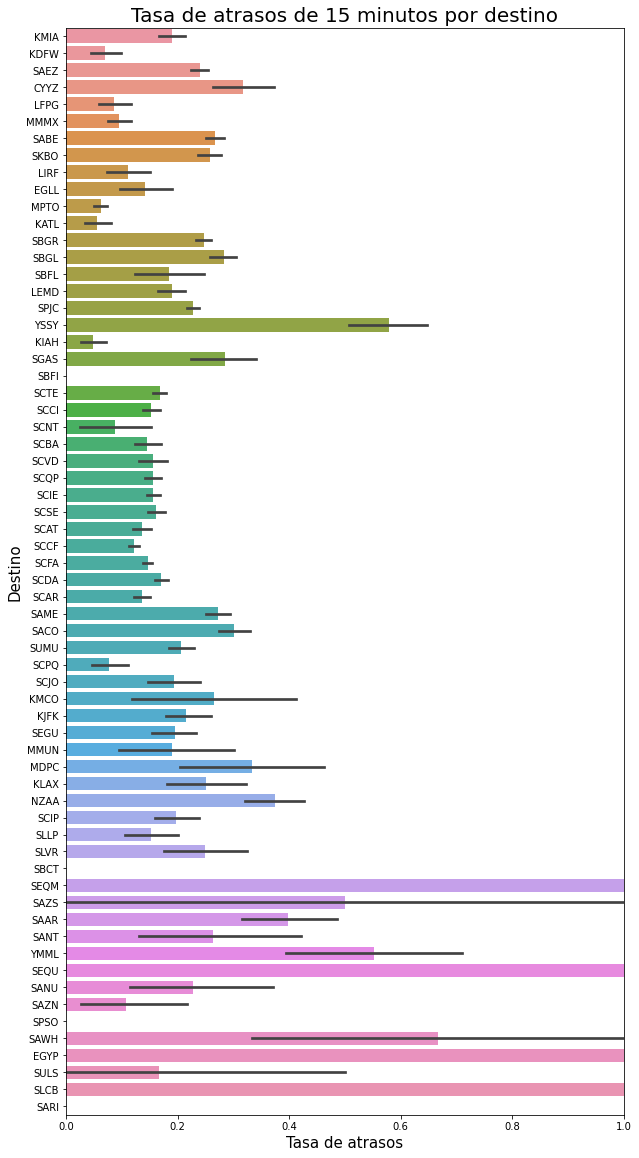

In [34]:
fig, ax = plt.subplots(figsize=(10, 20))
ax = sns.barplot(x='atraso_15', y='Des-I', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por destino', fontsize=20)
ax.set_xlabel('Tasa de atrasos', fontsize=15)
ax.set_ylabel('Destino', fontsize=15)
ax.set_xlim(0, 1)

(0.0, 1.0)

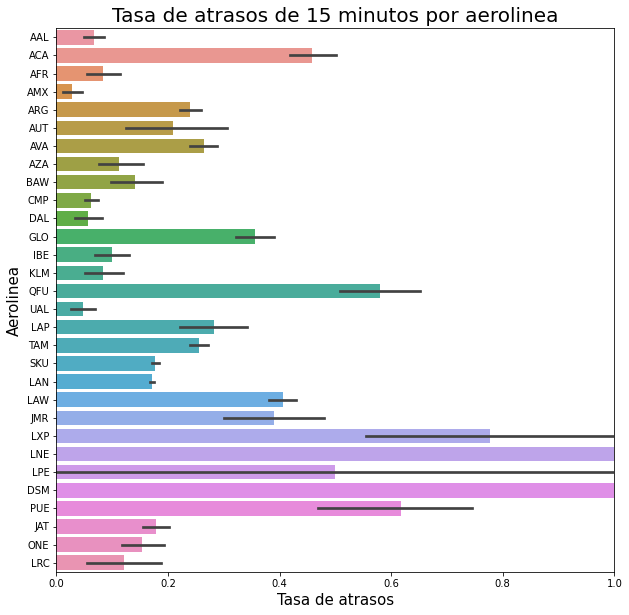

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.barplot(x='atraso_15', y='Emp-I', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por aerolinea', fontsize=20)
ax.set_xlabel('Tasa de atrasos', fontsize=15)
ax.set_ylabel('Aerolinea', fontsize=15)
ax.set_xlim(0, 1)

(0.0, 1.0)

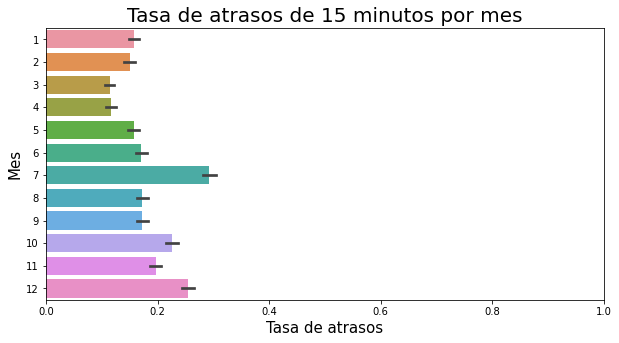

In [36]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.barplot(x='atraso_15', y='MES', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por mes', fontsize=20)
ax.set_xlabel('Tasa de atrasos', fontsize=15)
ax.set_ylabel('Mes', fontsize=15)
ax.set_xlim(0, 1)

(0.0, 1.0)

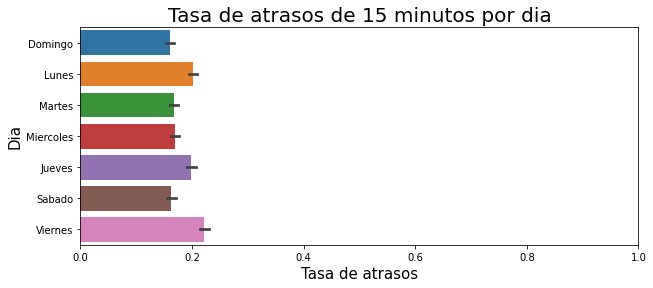

In [37]:
fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.barplot(x='atraso_15', y='DIANOM', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por dia', fontsize=20)
ax.set_xlabel('Tasa de atrasos', fontsize=15)
ax.set_ylabel('Dia', fontsize=15)
ax.set_xlim(0, 1)

(0.0, 1.0)

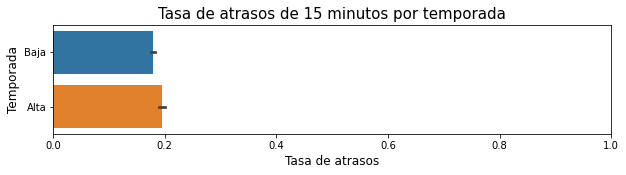

In [38]:
fig, ax = plt.subplots(figsize=(10, 2))
ax = sns.barplot(x='atraso_15', y='temporada_alta', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por temporada', fontsize=15)
ax.set_xlabel('Tasa de atrasos', fontsize=12)
ax.set_ylabel('Temporada', fontsize=12)
ax.set_yticklabels(['Baja', 'Alta'])
ax.set_xlim(0, 1)

(0.0, 1.0)

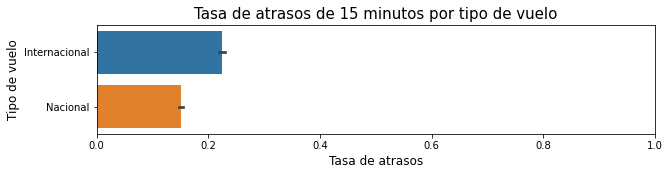

In [39]:
fig, ax = plt.subplots(figsize=(10, 2))
ax = sns.barplot(x='atraso_15', y='TIPOVUELO', data=data, orient='h', ax=ax)
ax.set_title('Tasa de atrasos de 15 minutos por tipo de vuelo', fontsize=15)
ax.set_xlabel('Tasa de atrasos', fontsize=12)
ax.set_ylabel('Tipo de vuelo', fontsize=12)
ax.set_yticklabels(['Internacional', 'Nacional'])
ax.set_xlim(0, 1)

Se calcula la desviacion estandar de cada uno de los features graficados

In [40]:
# calculate variance for each feature
for col in ['Des-I', 'Emp-I', 'MES', 'DIANOM', 'temporada_alta', 'TIPOVUELO']:
    data_grupo = data.groupby(col)
    atrasos_group = data_grupo['atraso_15'].mean()
    print(f'{col}: {atrasos_group.std()}')


Des-I: 0.23433885101889734
Emp-I: 0.26851907343318226
MES: 0.0530957341439194
DIANOM: 0.023767239307931325
temporada_alta: 0.01153880107291687
TIPOVUELO: 0.05252763858447203


Los features que esperaria que tengan mas influencia son los que tienen mayor variabilidad (o desviacion estandar) en la tasa de atrasos para cada categoria; en este caso:
- Destino
- Aerolinea

Y el que menos influencia debe tener es si es temporada alta o baja.

De toda maneras es importante hacer notar que tanto en Destino como Aerolinea hay casos donde se tienen muy pocos datos, por lo que la metricas metricas de promedio y desviacion estandar no son tan exactas.

# 4 - Modelos

Aqui se desarrollará:

4. Entrena uno o varios modelos (usando el/los algoritmo(s) que prefieras) para estimar la probabilidad de atraso de un vuelo.
Siéntete libre de generar variables adicionales y/o complementar con variables externas.

Primero que todo, se debe definir bien el problema, y como influyen las variables que se tienen.

Nota: Como se mensionó anteriormente, no tengo acceso a resolver preguntas con un experto en logistica de aerolineas, asi que solo puedo suponer cosas para este analisis

Se quiere crear un modelo capaz de predecir si un vuelo se atrasará, y por supuesto, esto solo es util si el vuelo aun no ocurre; por lo que entiendo, la informacion de operacion se genera cuando el vuelo realmente se pone en marcha, o muy cerca de ese momento; por ejemplo, el tiempo de partida real 'Fecha-O' se genera ahi; lo que significa que solo seria de utilidad usar la infomacion de programacion, ya que es la unica informacion que se poseerá cuando el modelo puede predecir algo futuro de utilidad. De todas maneras, la informacion de programacion y de operacion es igual para la gran mayoria de los casos, por lo que si se eliminasen los distintos, no bajaria mucho la cantidad de datos, y haria innecesario ocupar la informacion de programacion y operacion en conjunto; resultado en la utilizacion de los mismos features. Esto elimina los features:
- *Fecha-O*
- *Vlo-O*
- *Ori-O*
- *Des-O*
- *Emp-O*

Anteriormente vimos que la informacion de 'OPERA', 'SIGLAORI' y 'SIGLADES' es la misma que en otras columnas, solo repetida en otra forma, por lo que tampoco son necesarios. Se eliminan:
- *OPERA*
- *SIGLAORI*
- *SIGLADES*

La columna 'Ori-I' tiene solo una categoria que se repite, por lo que no agrega informacion (al menos actualmente, con los datos de este dataset); de la misma manera, 'AÑO' tiene casi unicamente el año 2017, por lo que tampoco aporta informacion. Se eliminan:
- *Ori-I*
- *AÑO*

La informacion de 'Fecha-I' solo es util para el calculo del atraso, al igual que 'Fecha-O'; por lo que ya no son necesarias. Ademas, como la fecha es algo unico, podria crear problemas en las capacidades de generalizacion del modelo, ya que el test siempre tendrá valores de fecha que nunca fueron vistos en el entrenamiento. Se elimina:
- *Fecha-I*

Segun lo que entiendo, el numero de vuelo 'Vlo-I' es solo un numero que se asigna como indice en la programacion de vuelo, para mantener un orden de inventario; por lo que no deberia aportar informacion para la prediccion de atrasos. Se elimina:
- *Vlo-I*

La columna 'dif_min' es solo otra forma del target 'atraso_15', por lo que por supuesto no puede ser utilizado para predecir. Se elimina:
- 'dif_min' 

Para las demás columnas ('Des-I', 'Emp-I', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'temporada_alta', 'periodo_dia') se revisará la desviacion estandar, como indicador de cuanta informacion pueden aportar.

In [50]:
# calculate variance for each feature
std_series = pd.Series(dtype=float)
for col in ['Des-I', 'Emp-I', 'DIA', 'MES', 'DIANOM', 'TIPOVUELO', 'temporada_alta', 'periodo_dia']:
    data_grupo = data.groupby(col)
    atrasos_group = data_grupo['atraso_15'].mean()
    std_series[col] = atrasos_group.std()
print(std_series.sort_values())

temporada_alta    0.011539
DIA               0.022539
periodo_dia       0.022662
DIANOM            0.023767
TIPOVUELO         0.052528
MES               0.053096
Des-I             0.234339
Emp-I             0.268519
dtype: float64


Podemos ver que las columnas que mas aportan informacion son: 'Emp-I' y 'Des-I' con aprox 0.2 de std, seguidas por 'MES' Y 'TIPOVUELO' con 0.05 aprox, y luego 'DIANOM', 'periodo_dia', 'DIA' y 'temporada_alta' al final con 0.02 o menos.

Debido a que 'DIANOM', 'periodo_dia', 'DIA' y 'temporada_alta' tienen muy baja desviacion estandar, y en general no tienen pocas categorias (lo cual incrementará la dimensionalidad del problema) no se trabajará con ellas. Se eliminan:
- *DIANOM*
- *periodo_dia*
- *DIA*
- *temporada_alta*

Esto nos deja con 'Des-I', 'Emp-I', 'MES' y 'TIPOVUELO'. Estos pueden separarse en 2 tipos de datos categoricos:
1. Ordinales: 'MES'
2. Nominales: 'Des-I', 'Emp-I' y 'TIPOVUELO'

'MES' ya está en valores numericos, por lo que no es necesario transformarlo. Los nominales si tienen que ser transformados para ser utilizados.

Lo tipico sería utilizar one hot encoding, pero se verá primero la cantidad de categorias.

In [53]:
# amount of unique values for each feature
for col in ['Des-I', 'Emp-I', 'TIPOVUELO']:
    print(f'{col}: {data[col].nunique()}')

Des-I: 64
Emp-I: 30
TIPOVUELO: 2


Vemos que hay una alta cantidad de categorias, lo que significa que si utilizamos one hot encoding, terminariamos con casi 96 features, lo que es bastante.

Veamos el conteo de datos por cada categoria:

Text(0, 0.5, 'Cantidad de vuelos')

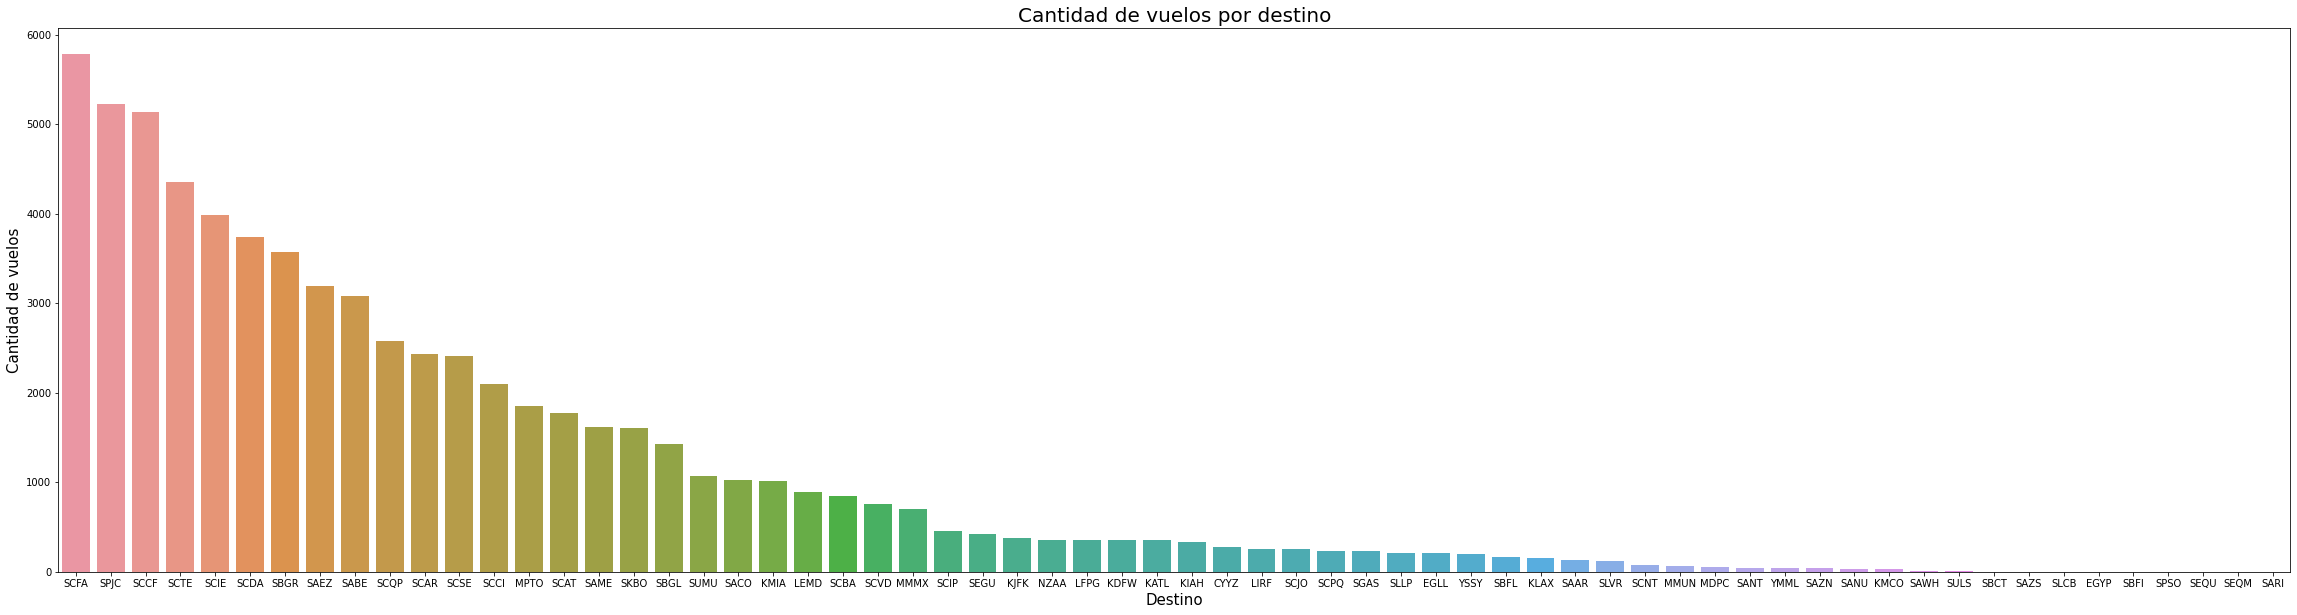

In [67]:
# ordered countplot for Des-I
fig, ax = plt.subplots(figsize=(40, 10))
ax = sns.countplot(x='Des-I', data=data, ax=ax, order=data['Des-I'].value_counts().index)
ax.set_title('Cantidad de vuelos por destino', fontsize=20)
ax.set_xlabel('Destino', fontsize=15)
ax.set_ylabel('Cantidad de vuelos', fontsize=15)

Text(0, 0.5, 'Cantidad de vuelos')

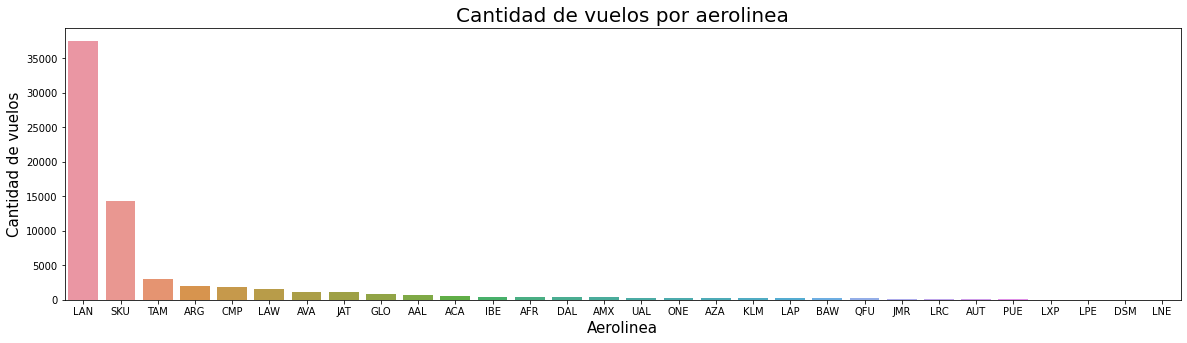

In [74]:
# ordered countplot for Emp-I
fig, ax = plt.subplots(figsize=(20, 5))
ax = sns.countplot(x='Emp-I', data=data, ax=ax, order=data['Emp-I'].value_counts().index)
ax.set_title('Cantidad de vuelos por aerolinea', fontsize=20)
ax.set_xlabel('Aerolinea', fontsize=15)
ax.set_ylabel('Cantidad de vuelos', fontsize=15)


Text(0, 0.5, 'Cantidad de vuelos')

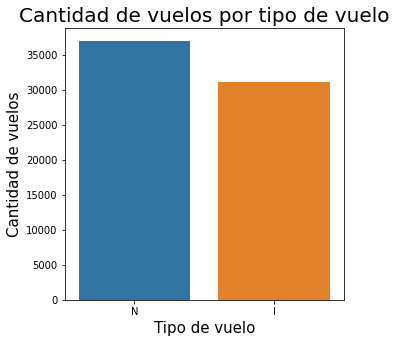

In [76]:
# ordered countplot for TIPOVUELO
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x='TIPOVUELO', data=data, ax=ax, order=data['TIPOVUELO'].value_counts().index)
ax.set_title('Cantidad de vuelos por tipo de vuelo', fontsize=20)
ax.set_xlabel('Tipo de vuelo', fontsize=15)
ax.set_ylabel('Cantidad de vuelos', fontsize=15)


Vemos que para el destino y para la aerolinea hay muchos casos donde una categoria ocurre muy pocas veces.

Existen distintas formas de transformar estos features para ser utilizados en un modelo, si solo utilizamos directamente One Hot Encoding, terminaremos con muchos datos; otra opcion seria utilizar otros tipos de encoding, como Binary Encoding, Frequency Encoding, u otros; tambien está la posibilidad de eliminar o agrupar las categorias que ocurren con poca frecuencia, para terminar con menos features.

Para ser honesto no tengo tanta experiencia con Sparse data para saber qué metodologias suelen obtener mejores resultados, por lo que en esta ocacion, se utilizará One Hot Encoding directo seguido de TruncatedSVD para reducir la dimensionalidad.

In [84]:
# use sklearn OneHotEncoder to encode categorical features
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data[['Des-I', 'Emp-I', 'TIPOVUELO']])
encoded_feat = enc.transform(data[['Des-I', 'Emp-I', 'TIPOVUELO']]).toarray()

# svd for encoded data
svd = TruncatedSVD(n_components=90)
svd.fit(encoded_feat)


TruncatedSVD(n_components=90)

Vemos cuantas componentes son necesarias para mantener una buena cantidad de varianza

Number of principal components that explain 90% of the variance: 26


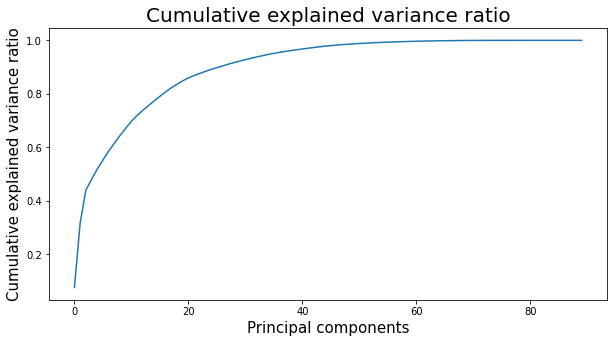

In [97]:
# plot cumulative explained variance
cumsum_var = np.cumsum(svd.explained_variance_ratio_)
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.lineplot(x=np.arange(90), y=cumsum_var, ax=ax)
ax.set_title('Cumulative explained variance ratio', fontsize=20)
ax.set_xlabel('Principal components', fontsize=15)
ax.set_ylabel('Cumulative explained variance ratio', fontsize=15)

# find the number of principal components that explain 95% of the variance
var_90 = np.where(cumsum_var >= 0.90)[0][0]
print(f'Number of principal components that explain 90% of the variance: {var_90}')


Con 26 componentes conservamos el 90% de la varianza de los datos con one hot encode; por lo que se utilizarán 26 componentes

Creamos una funcion para realizar el preprocesamiento

In [105]:
def preprocess_data(
    data: pd.DataFrame,
    onehot: OneHotEncoder,
    svd: TruncatedSVD,
    scaler: StandardScaler,
    cols_to_onehot: List[str]=None,
    cols_extra: List[str]=None,
    mode: str='train'
    ) -> pd.DataFrame:
    """
    Preprocess data for the model, by:
    - One hot encoding the 'cols_to_onehot' columns
    - Applying SVD to the one hot encoded data
    - Concatenating the encoded data with the 'cols_extra' columns
    - Scaling the data using the scaler

    Parameters
    ----------
    data : pd.DataFrame
        Data to preprocess
    onehot : OneHotEncoder
        One hot encoder to use
    svd : TruncatedSVD 
        TruncatedSVD to use
    scaler : StandardScaler
        Scaler to use
    cols_to_onehot : List[str]
        List of columns to one hot encode
    cols_extra : List[str] 
        List of columns to concatenate with the encoded data
    mode : str
        Function mode 'train' or 'test', whether to fit the encoder, svd and scaler or not 
    """
    data_to_onehot = data[cols_to_onehot]
    data_extra = data[cols_extra].to_numpy()

    if mode == 'train':
        # one hot encode the data and apply SVD
        data_encoded = onehot.fit_transform(data_to_onehot).toarray()
        data_reduced = svd.fit_transform(data_encoded)

        # add extra columns
        data_concat = np.concatenate([data_reduced, data_extra], axis=1)
        # scale data
        data_processed = scaler.fit_transform(data_concat)

    elif mode == 'test':
        # one hot encode the data and apply SVD
        data_encoded = onehot.transform(data_to_onehot).toarray()
        data_reduced = svd.transform(data_encoded)

        # add extra columns
        data_concat = np.concatenate([data_reduced, data_extra], axis=1)
        # scale data
        data_processed = scaler.transform(data_concat)

    return data_processed

Ahora definimos el entrenamiento a utilizar.

Como se mensionó antes, lo ideal seria entrenar con un par de años y testear con un año siguiente, para evitar que el test sea muy similar al entrenamiento; ya que el modelo puede aprender comportamientos fortuitos en el año, y si el train y test son del mismo año, no habrá forma de comprobar que el modelo no los ha aprendido. Pero como esto no es solucionable con este dataset (a menos que se elimine la columna de MES, que tiene la informacion temporal), se realizará gridsearch con el entrenamiento; no se realizará cross validation porque la cantidad de data no es tan baja, y podria resultar en un computo muy costoso.

Ademas de lo anterior, se utilizará el modelo XGBoost, y se buscarán los mejores parametros utilizando un set de validacion, maximisando la metrica f1_score

Se separan los set de entrenamiento, validacion y test

In [110]:
X_full = data[['Des-I', 'Emp-I', 'MES', 'TIPOVUELO']]
y_full = data['atraso_15'].to_numpy()

# split data into train, test and validation sets
X_temp, X_test, y_temp, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)
del X_temp, y_temp

# define one hot encoder, svd and scaler
onehot = OneHotEncoder(handle_unknown='ignore')
svd = TruncatedSVD(n_components=26)
scaler = StandardScaler()

# preprocess data
X_train_processed = preprocess_data(X_train, onehot, svd, scaler, cols_to_onehot=['Des-I', 'Emp-I', 'TIPOVUELO'], cols_extra=['MES'], mode='train')
X_val_processed = preprocess_data(X_val, onehot, svd, scaler, cols_to_onehot=['Des-I', 'Emp-I', 'TIPOVUELO'], cols_extra=['MES'], mode='test')
X_test_processed = preprocess_data(X_test, onehot, svd, scaler, cols_to_onehot=['Des-I', 'Emp-I', 'TIPOVUELO'], cols_extra=['MES'], mode='test')

# show shape of processed data
print(f'Train data shape: {X_train_processed.shape}')
print(f'Val data shape: {X_val_processed.shape}')
print(f'Test data shape: {X_test_processed.shape}')

Train data shape: (40848, 27)
Val data shape: (13616, 27)
Test data shape: (13617, 27)


Ahora se define los parametros para el grid search, y se buscan los mejores parametros para XGBoost (puede tardar unos 4-5min)

In [124]:
# define search parameters for parameter grid
search_params = {'max_depth':[x for x in range(7,11)],
                'eta':[0.05*x for x in range(1,5)],
                'lambda':[0.05*x+1 for x in range(3,9)]
                }

# define model and metric
model_class = XGBClassifier
maximize_metric = f1_score

# placeholders for model evaluation
best_score = 0
best_params = None

# run parameter grid
param_grid = ParameterGrid(search_params)
for params in param_grid:
    model = model_class(**params, use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train_processed, y_train)
    pred = model.predict(X_val_processed)
    score = maximize_metric(y_val, pred)
    if score > best_score:
        best_score = score
        best_params = params

print(f'best score: {best_score}\nbest params:{best_params}')

best score: 0.11546685673556664
best params:{'eta': 0.2, 'lambda': 1.2, 'max_depth': 10}


Ahora usamos el modelo con los mejores parametros y lo utilizamos para predecir el test

In [125]:
# train final model
model = model_class(**best_params, use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_processed, y_train)

# predict on test data
pred = model.predict(X_test_processed)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
print(f'Test f1 score: {f1_score(y_test, pred)}')

Test accuracy: 0.8163325255195711
Test f1 score: 0.13788348845225787


# 5 - Evaluación

Aqui se responderá:

5. Evalúa tu modelo. ¿Qué performance tiene? ¿Qué métricas usaste para evaluar esa performance y por qué? ¿Por qué
elegiste ese algoritmo en particular? ¿Qué variables son las que más influyen en la predicción? ¿Cómo podrías mejorar la
performance?

In [126]:
# predict on test data
pred = model.predict(X_test_processed)
print(f'Test accuracy: {accuracy_score(y_test, pred)}')
print(f'Test f1 score: {f1_score(y_test, pred)}')
print(confusion_matrix(y_test, pred))


Test accuracy: 0.8163325255195711
Test f1 score: 0.13788348845225787
[[10916   132]
 [ 2369   200]]


¿Qué performance tiene?

La tasa de aciertos del modelo es de 81,6%, pero f1 score es de 0.137, lo cual indica que realmente el modelo es pesimo

¿Qué métricas usaste para evaluar esa performance y por qué?

F1 score, suele ser la mejor metrica de un solo numero para clasificacion; como se puede ver, accuracy es relativamente alto 81,6%, pero esto se debe a que la mayoria de los datos se clasifican como "no atraso", y como esta es la clase mas abundante, resulta en un alto accuracy. La matriz de confusion muestra como se distribullen los resultados de classificacion por clase, por lo que es util para ver el detalle. 

¿Por qué elegiste ese algoritmo en particular?

XGBoost lo elegí porque es un modelo bastante potente para problemas de ML clasicos de tabla con filas de datos independientes (no series temporales, o imagenes); el preprocesamiento porque es una forma más estandar de reducir los datos, que no requiere mucha experiencia en cuales son las mejores metodologias para trabajar con datos con high sparsity.

¿Qué variables son las que más influyen en la predicción?

Como se describió antes, se espera que los features con mayor desviacion estandar tengan mas influencia, es decir, el Destino y la Aerolinea. Como parte del preprocesamiento es reduccion de dimensionalidad, se pierde la intuicion de cada feature despues de esto, por lo que aunque se pueda ver que features influyen mas en la clasificacion del modelo XGBoost entrenado, no serviria de mucho.



¿Cómo podrías mejorar la performance?

Rapidamente, probando otros modelos y otros preprocesamientos; como fue mensionado antes, existen distintas formas de trasformar la data categorica a algo que pueda utilizar un modelo, otros tipos de encoding, como Binary Encoding o Frequency Encoding; tambien está la posibilidad de eliminar o agrupar las categorias que ocurren con poca frecuencia, para terminar con menos features. Tambien, debido a que la cantidad de datos no es tan baja, se podrian utilizar redes neuronales, las cuales podrian tener mejores resultados.

Como fue visto en el analisis, de todas maneras pareciese ser que faltan muchos datos, no hay vuelos que lleguen a Santiago, solo los que salen; ademas, solo hay un año de informacion. Si se tuviese toda la data se podrian entrenar redes neuronales con mas seguridad, las que sueles ser buenas con alta cantidad de datos.

Finalmente está la posibilidad de realizar un modelo mucho mas complejo, para este analisis se consideró los vuelos como totalmente independientes, pero en realidad es un problema de logistica que relaciona los vuelos, es decir, podria ser util usar la informacion de los vuelos recientes para predecir; pero esto es un modelo más complejo, que requiere más analisis y trabajo.